# ampicillin biochemistry specific activity

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

##Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/ampicillin_biochemistry'
if not os.path.exists(OUTPUT_DIR): os.mkdir(OUTPUT_DIR)

AMP_SHEETNAME = 'biochem_amp_raw'

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
def add_repnum_manuscriptname(row):
    '''
    add the manuscript name and and replicate name from the name used
    in the raw data into the melted dataframe
    '''
    name_repnum = row['variable']
    row['rep_num'] = int(name_repnum[-1])
    row['sample_id'] = name_repnum[0:-3]
    return row

#load data
narrow_df = pd.concat([
    
    pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name=AMP_SHEETNAME
    ).iloc[0:28,].melt(['TIME']),

    pd.read_excel(
        FHS.get_data_filename(),
        sheet_name=AMP_SHEETNAME, 
        header=32
    ).iloc[:,:4].melt(['TIME'])

]).reset_index().apply(
    lambda row: add_repnum_manuscriptname(row), 
    axis=1
).drop(['index', 'variable'], axis=1)

narrow_df = FHS.add_manuscript_name_to_df(
    narrow_df, 
    synonym_column='sample_id',
    new_column='manuscript_name'
).drop(['sample_id'], axis=1)

## Data Analysis

In [5]:
#############################
#                           #
#                           #
#        FUNCTiONS          #
#                           #
#                           #
#############################
def calculate_rmsd(slope, intersect, actual_x_values, actual_y_values):
    '''
    calculate the rmsd between predicted and actual values
    '''
    predicted_values = []
    for actual_x in actual_x_values:
        predicted_values.append(
            slope * actual_x + intersect
        )
    return np.sqrt(
        np.sum(
            (np.array(predicted_values) - np.array(actual_y_values)) ** 2
        ) / len(predicted_values)
    )

def window_linear_regression(narrow_df, window_size=5):
    '''
    repeately perform a linear regression on each design over the number
    of timepoints specified by 'window_size'.
    '''
    #load molecular weights of each design
    # using https://www.bioinformatics.org/sms/prot_mw.html
    molecular_weights = {
        'WT TEM-1': 28.91,
        '50.a': 28.34, '50.b': 27.11,
        '70.a': 28.25, '70.b': 27.87,
        '80.a': 28.34, '80.b': 28.36,
        '90.a': 28.86, '90.b': 28.49,
        '95.a': 28.63, '95.b': 28.71,
        '98.a': 28.77, '98.b': 28.62,
        'rw-consensus': 27.98,
        'opt.b': 28.48,
        'opt.a': 28.73,
        'neg. ctrl': 28.89,
        'pbs': 28.91 #SET TO WT
    }
    for design in molecular_weights.keys():
        molecular_weights[design] *= 1000

    lin_reg_data = []

    for manuscript_name in np.unique(narrow_df.manuscript_name):
        for rep_num in [1,2,3]:
            conditions = narrow_df[
                (narrow_df.manuscript_name == manuscript_name) & 
                (narrow_df.rep_num == rep_num)
            ].sort_values(by='TIME', ascending=True)

            for i in range(0, len(conditions)-window_size):
                window_times = conditions[i:i+window_size].TIME.tolist()
                window_absorbances = conditions[i:i+window_size].value.tolist()
                res = linregress(window_times, window_absorbances)
                design = np.unique(conditions.manuscript_name)[0]
                rep_num = np.unique(conditions.rep_num)[0]
                value = {
                    'manuscript_name': design,
                    'rep_num': rep_num,
                    'start_time_index': i,
                    'start_time_sec': window_times[0],
                    'end_time_sec': window_times[len(window_times)-1],
                    'slope': res.slope,
                    'intercept': res.intercept,
                    'window_times': pd.array(window_times),
                    'window_absorbances': pd.array(window_absorbances),
                    'rmsd': calculate_rmsd(
                        res.slope, res.intercept, 
                        pd.array(window_times), 
                        pd.array(window_absorbances)
                    ),
                    'molecular_weight': molecular_weights[design]
                }
                lin_reg_data.append(value)
    toreturn = pd.DataFrame.from_dict(lin_reg_data)
    return toreturn

In [6]:
#Perform a linear regression of size 5 across every timepoint
amp_lr_win5_df = window_linear_regression(narrow_df, window_size=5)

## Plot data

In [7]:
def smart_jitter(bp, df, ax, 
                 actual_sample_order,
                 sample_colname='manuscript_name', 
                 na_samples=[],
                 rep_colname='rep_num',
                 value_colname='specific_activity'):
    #plot raw datapoints, but "smart" jitter so all are visible
    #bp = barplot output
    rawdatapoints = {'x':[], 'y': []}
    for idx, samplename in enumerate(actual_sample_order):
        bar_details = bp.patches[idx]
        padding = 0.2 * bar_details.get_width()
        bar_x_start = bar_details.xy[0] + padding
        bar_width = bar_details.get_width() - (2 * padding)

        rep_spacing = 1 / 2 * bar_width
        if samplename in na_samples:
            ax.text(
                x=bar_x_start+(bar_width/2), y=40,
                horizontalalignment='center', verticalalignment='center',
                s='N/A', fontsize=14
            )
        else:
            tmp_df = df[df[sample_colname]==samplename]
            for i in range(0, 3):
                rawdatapoints['x'].append(bar_x_start + (i * rep_spacing))
                tmp_df = df[(
                    (df[sample_colname]==samplename) &
                    (df[rep_colname]==i+1)
                )]
                rawdatapoints['y'].append(tmp_df[value_colname])
        
    ax.scatter(
        x=rawdatapoints['x'], y=rawdatapoints['y'], 
        color='darkred', s=20, zorder=10,
        marker='D', linewidth=0
    )

def get_best_slopes_df(df, rmsd_cutoff):
    tmpdf = df[df.rmsd <= rmsd_cutoff].reset_index(drop=True)
    return tmpdf.loc[tmpdf.groupby(['manuscript_name', 'rep_num']).slope.idxmin()].reset_index(drop=True)

def plotSpecificActivity(df_linear_fit, rmsd_cutoff=0.001):
    '''
    Final plot of the specific activityRight now activity assay is absorbance. 
       Starting enzyme 0.5 nanomolar:
          - enzyme molecular weight = 28.91 kilodaltons (WT) and 28.25 (70.1)
          - 1 dalton = 1 g / mol so 28910 and 28250 grams per mol
          - starting enzyme is 0.5 nanomolar in 0.1 mL = 0.0000000000005 mol (.5 pmol?)
          - 0.0000000000005 mol * X grams/mol = mass in grams
          - so 14.455 ng of WT enzyme and 14.125 of 70.1
       Starting AMP concentration is 0.08umol in 100uL
    '''
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)

    best_fit_slopes_df = get_best_slopes_df(df_linear_fit, rmsd_cutoff)
    
    #calculate specific activity = number of micromoles of product formed per milligram of enzyme per minute
    #   slope = change in absorbance
    #   amp concentration = 0.08 umol (note it is in 100 uL)
    #   mass of enzyme in mg = 0.5 mol * X mg/mol * 1000 mg/g
    #   time in minutes
    # absorbance unit per mg enzyme per minute
    best_fit_slopes_df['specific_activity'] = np.abs(best_fit_slopes_df.slope) \
        / 0.08 \
        / (0.0000000000005 * best_fit_slopes_df.molecular_weight * 1000) \
        / ((best_fit_slopes_df.end_time_sec - best_fit_slopes_df.start_time_sec) / 60)

    #add 50's even though they aren't there - will indicate N/A in plot
    best_fit_slopes_df = pd.concat([best_fit_slopes_df, pd.DataFrame(
        {
            'manuscript_name': ['50.a', '50.a', '50.a','50.b', '50.b', '50.b',],
            'rep_num': [1, 2, 3, 1, 2, 3],
            'specific_activity': [0, 0, 0, 0, 0, 0]
        }
    )]).reset_index()

    sample_order = FHS.get_sample_order(best_fit_slopes_df.manuscript_name)

    bp = sns.barplot(
        data=best_fit_slopes_df, x='manuscript_name', y='specific_activity',
        errorbar='sd', color='lightgray', order=sample_order
    )

    smart_jitter(bp, best_fit_slopes_df, ax, sample_order, na_samples=['50.a', '50.b'])
    ax.set_title('Biochemistry of Ampicillin Hydrolysis', fontsize=20)
    ax.set_ylabel('Specific Activity\n(change in absorbance per mg enzyme per minute)')
    ax.set_xlabel('Design')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, 
                       ha='right', rotation_mode='anchor')
    
    #save figure
    fig.savefig(OUTPUT_DIR+'/amp_biochem_specificactivity.pdf')

    #save the top slopes that are used in the main figure to a csv
    #best_fit_slopes_df.to_csv(OUTPUT_DIR+'/processed_amp_specific_activity_data.tab', sep='\t')

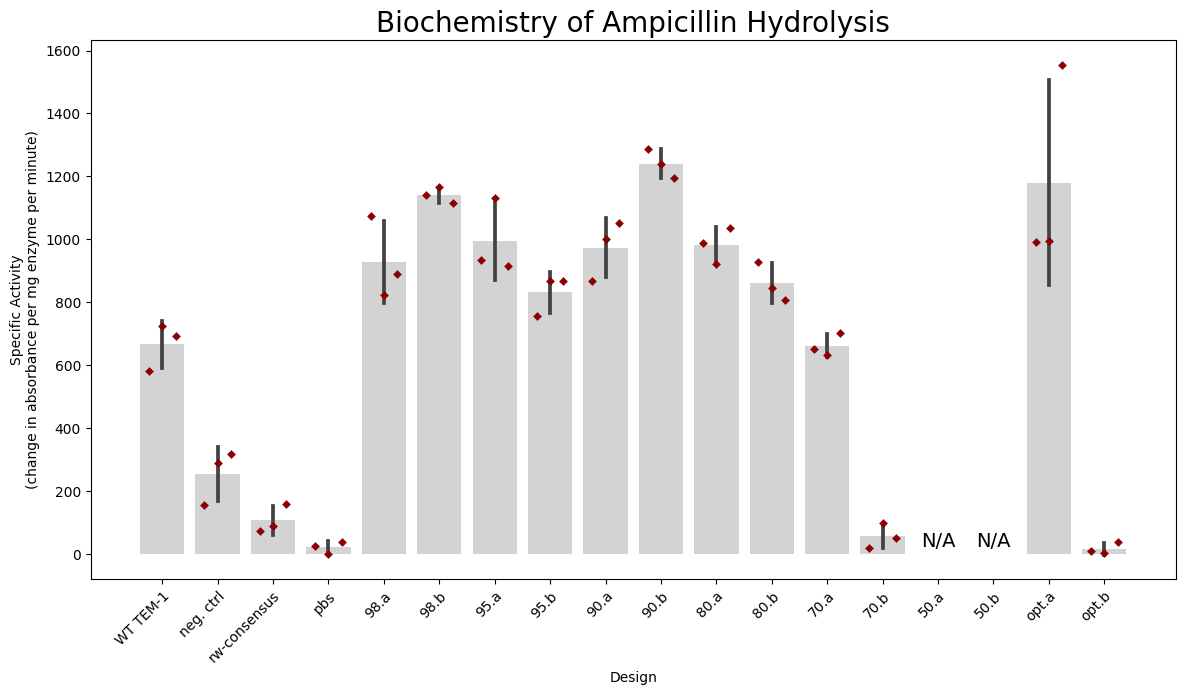

In [8]:
plotSpecificActivity(amp_lr_win5_df, rmsd_cutoff=0.001)